In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb

from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics   #Additional     scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Users/suncan/myenv/venv/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/suncan/myenv/venv/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
train = pd.read_csv('../../raw/LiChuan/trainSaleDate.csv')
# 去掉 2012 年数据, 噪音太多
train = train.drop(train['year']==2012)

train.drop_duplicates(inplace=True)
labels = train.sale_quantity
train = train.drop(['class_id','sale_quantity', 'sale_date'], axis=1)

# train_test = pd.concat([train, test]).reset_index(drop=True)
year_dummies = pd.get_dummies(train['year'], prefix='year')
month_dummies = pd.get_dummies(train['month'], prefix='month')
train = pd.concat([train, year_dummies], axis=1)
train = pd.concat([train, month_dummies], axis=1)
train = train.drop(['year', 'month'], axis=1)
train.fillna(0.0, inplace=True)

# 获取 2017-10 数据作为测试集
test_X = train[-140:]
test_Y = labels[-140:]

# 2012-01 至 2017-10 作为训练集
train_X = train[:-140]
train_Y = labels[:-140]

背景：数据科学里，首先要对数据特征的提取建模，然后用机器学习模拟预测。目前来说，工业界暂时不清楚，但是在只要涉及数据科学的比赛，机器学习模型肯定少补了Xgboost。Xgboost的参数非常繁多（50多个参数），本次主要介绍如何进行Xgboost调参

# 调参原理：
### 1、利用sklearn的网格搜索GridSearchCV进行调试，但是GridSearchCV无法直接对xgboost进行调试
### 2、利用xgboost的sklearn接口[XGBRegressor/XGBClassifier](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn),利用接口，将xgboost的参数带入到GridSearchCV进行遍历调优

# 调参原则：
### 1、参数先粗调再微调
### 2、参数先调对结果影响大的（哪些影响大，可以上网先找找）
### 3、分批次调参

# Xgboost的参数

- General parameters relates to which booster we are using to do boosting, commonly tree or linear model
- Booster parameters depends on which booster you have chosen
- Learning Task parameters that decides on the learning scenario, for example, regression tasks may use different parameters with ranking tasks.
- Command line parameters that relates to behavior of CLI version of xgboost.

# 调参的顺序：
### 1、选定一组基准参数，这些参数有经验的话，用经验值，没有经验可以用官方的默认值
### 2 、max_depth 和 min_child_weight 参数调优
### 3、gamma参数调优
### 4、调整subsample 和 colsample_bytree 参数调优
### 5、正则化参数调优（reg_alpha、reg_lambda）。
### 6、降低学习率和使用更多的树（learning_rate、n_estimators）
### 7、可以探索的参数max_delta_step 、scale_pos_weight、base_score

In [4]:
def modelfit(alg,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain =xgb.DMatrix(train_X,label=train_Y)
        xgtest = xgb.DMatrix(test_X)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds,show_stdv=False)
        alg.set_params(n_estimators=cvresult.shape[0])#cvresult.shape[0]和alg.get_params()['n_estimators']值一样
    
    #Fit the algorithm on the data
    alg.fit(train_X, train_Y,eval_metric='rmse') 
    #Predict training set:
    dtrain_predictions = alg.predict(train_X)
    #Print model report:
    print(" Score (Train): %f" % metrics.mean_squared_error(train_Y.values, dtrain_predictions))
    #Predict on testing data:
    dtest_predictions = alg.predict(test_X)
    print("Score (Test): %f" % metrics.mean_squared_error(test_Y.values, dtest_predictions))
                

### 1、选定一组基准参数，这些参数有经验的话，用经验值，没有经验可以用官方的默认值

In [ ]:
  
xgb1 = XGBRegressor(booster='gbtree', 
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1.1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)
modelfit(xgb1)

 Score (Train): 8054.387826
 
Score (Test): 27418.413465

# xgb1的参数
base_score=0.5, booster='gbtree', colsample_bylevel=1,
colsample_bytree=0.8, eval_metric='rmse', gamma=0.1,
learning_rate=0.1, max_delta_step=0, max_depth=5,
min_child_weight=1.1, missing=None, n_estimators=400, n_jobs=1,
nthread=4, objective='reg:linear', random_state=0, reg_alpha=0,
reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
subsample=0.8, tree_method='exact'

### 2、 max_depth 和 min_child_weight 参数调优

In [88]:
%%time

#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':[3,5,7,9],
    'min_child_weight':[1,3,5]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(booster='gbtree', 
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1.1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27), 
                       param_grid = param_test1, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_X,train_Y)

CPU times: user 8.41 s, sys: 323 ms, total: 8.73 s
Wall time: 1min 50s


In [89]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -37307.30173, std: 20190.10346, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -37858.56838, std: 20117.31618, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -37074.47698, std: 18889.70050, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -33870.23259, std: 19987.57504, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -33240.71438, std: 18837.21289, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -36997.23968, std: 22463.08107, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -33965.78497, std: 18547.66643, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -34735.79444, std: 20149.70986, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -37111.82576, std: 22824.75284, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -35508.45759, std: 19274.54528, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -35914.95148, std: 20508.98895, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -36943.84821,

###  不放心的话尝试一下其他值

In [91]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1b = {
    'min_child_weight':[6,8,10,12]
}
gsearch1b = GridSearchCV(estimator = XGBRegressor(booster='gbtree', 
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1.1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27), 
                       param_grid = param_test1b, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1b.fit(train_X,train_Y)

CPU times: user 7.28 s, sys: 187 ms, total: 7.46 s
Wall time: 36.1 s


In [92]:
gsearch1b.grid_scores_, gsearch1b.best_params_, gsearch1b.best_score_

([mean: -37171.16050, std: 21067.04892, params: {'min_child_weight': 6},
  mean: -36495.04327, std: 20191.87333, params: {'min_child_weight': 8},
  mean: -36298.35708, std: 19605.68520, params: {'min_child_weight': 10},
  mean: -35836.89718, std: 18897.25594, params: {'min_child_weight': 12}],
 {'min_child_weight': 12},
 -35836.89718422033)

### 3、gamma参数调优

In [95]:
%%time
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(booster='gbtree', 
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 3,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27), 
                       param_grid = param_test3, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_X,train_Y)

CPU times: user 7.82 s, sys: 227 ms, total: 8.05 s
Wall time: 48.6 s


In [96]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -33240.71438, std: 18837.21289, params: {'gamma': 0.0},
  mean: -33240.71438, std: 18837.21289, params: {'gamma': 0.1},
  mean: -33240.71438, std: 18837.21289, params: {'gamma': 0.2},
  mean: -33240.71438, std: 18837.21289, params: {'gamma': 0.3},
  mean: -33240.71438, std: 18837.21289, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -33240.714381367696)

### 4、调整subsample 和 colsample_bytree 参数调优

In [97]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(booster='gbtree', 
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 3,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27), 
                       param_grid = param_test4, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_X,train_Y)

CPU times: user 9.08 s, sys: 409 ms, total: 9.49 s
Wall time: 1min 56s


In [98]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -33599.72943, std: 18191.85111, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -34504.14133, std: 18332.87810, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -34742.90855, std: 20106.86473, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -34180.71176, std: 21119.88727, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -33706.05489, std: 17873.54056, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -35365.73247, std: 20734.72408, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -36003.56230, std: 20460.12605, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -35102.41564, std: 20596.99663, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -34071.12767, std: 18824.45763, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -34306.79986, std: 18037.63492, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -33240.71438, std: 18837.21289, params: {'colsample_bytree': 0

### 5、正则化参数调优（reg_alpha、reg_lambda）

### 粗调

In [99]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor(booster='gbtree', 
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 3,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27), 
                       param_grid = param_test6, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train_X,train_Y)


CPU times: user 7.53 s, sys: 202 ms, total: 7.73 s
Wall time: 46.5 s


In [100]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -33240.71449, std: 18837.21316, params: {'reg_alpha': 1e-05},
  mean: -33240.70394, std: 18837.19242, params: {'reg_alpha': 0.01},
  mean: -33240.61475, std: 18837.01487, params: {'reg_alpha': 0.1},
  mean: -33655.05163, std: 19188.16195, params: {'reg_alpha': 1},
  mean: -33518.91580, std: 19324.08680, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 -33240.6147525903)

### 微调

In [101]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBRegressor(booster='gbtree', 
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 3,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27), 
                       param_grid = param_test7, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train_X,train_Y)



CPU times: user 7.49 s, sys: 199 ms, total: 7.69 s
Wall time: 46.2 s


In [102]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: -33240.71438, std: 18837.21289, params: {'reg_alpha': 0},
  mean: -33240.71515, std: 18837.21306, params: {'reg_alpha': 0.001},
  mean: -33240.71029, std: 18837.20469, params: {'reg_alpha': 0.005},
  mean: -33240.70394, std: 18837.19242, params: {'reg_alpha': 0.01},
  mean: -33240.66275, std: 18837.11462, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.05},
 -33240.66275176923)

### 6、降低学习率和使用更多的树（learning_rate、n_estimators）

In [139]:
%%time
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test9 = {
    'n_estimators':[50, 100, 200, 500,1000],
    'learning_rate':[0.001, 0.01, 0.05, 0.1,0.2]
}
gsearch9 = GridSearchCV(estimator = XGBRegressor(booster='gbtree', 
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 3,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    nthread=4,
                    scale_pos_weight=1,
                    reg_alpha=0.05,                           
                    seed=27), 
                       param_grid = param_test9, scoring='mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch9.fit(train_X,train_Y)



CPU times: user 18 s, sys: 400 ms, total: 18.4 s
Wall time: 11min 48s


In [140]:
gsearch9.grid_scores_, gsearch9.best_params_, gsearch9.best_score_

([mean: -269735.38582, std: 100248.84349, params: {'learning_rate': 0.001, 'n_estimators': 50},
  mean: -248451.90827, std: 91899.96797, params: {'learning_rate': 0.001, 'n_estimators': 100},
  mean: -211548.39700, std: 76958.64307, params: {'learning_rate': 0.001, 'n_estimators': 200},
  mean: -134974.04245, std: 47851.47997, params: {'learning_rate': 0.001, 'n_estimators': 500},
  mean: -73521.66556, std: 25935.98271, params: {'learning_rate': 0.001, 'n_estimators': 1000},
  mean: -134499.16558, std: 47613.16020, params: {'learning_rate': 0.01, 'n_estimators': 50},
  mean: -72947.14830, std: 26031.50160, params: {'learning_rate': 0.01, 'n_estimators': 100},
  mean: -39440.09082, std: 16239.31453, params: {'learning_rate': 0.01, 'n_estimators': 200},
  mean: -33312.98785, std: 18013.88261, params: {'learning_rate': 0.01, 'n_estimators': 500},
  mean: -33663.99313, std: 20179.74172, params: {'learning_rate': 0.01, 'n_estimators': 1000},
  mean: -36502.96591, std: 16225.13167, params: {

# 注意

### 调完参数之后有两种方式进行使用xgboost
#### 1、直接用接口XGBRegressor，fit之后在预测。好处：快，运行的后的效果还可以
### 2、用xgboost先训练，再预测。好处：鲁棒性比较高

### 首先将之前调完的参数，设置好

In [141]:
xgb9 = XGBRegressor(booster='gbtree', 
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 3,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=200,
                    nthread=4,
                    scale_pos_weight=1,
                    reg_alpha=0.05,                           
                    seed=27)

### 第一种方案fit之后，在predict预测

In [142]:
xgb9.fit(train_X,train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='rmse', gamma=0.1,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=200, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=0.05,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8, tree_method='exact')

In [187]:
sqrt(mean_squared_error(xgb9.predict(test_X),test_Y))

163.93821478808687

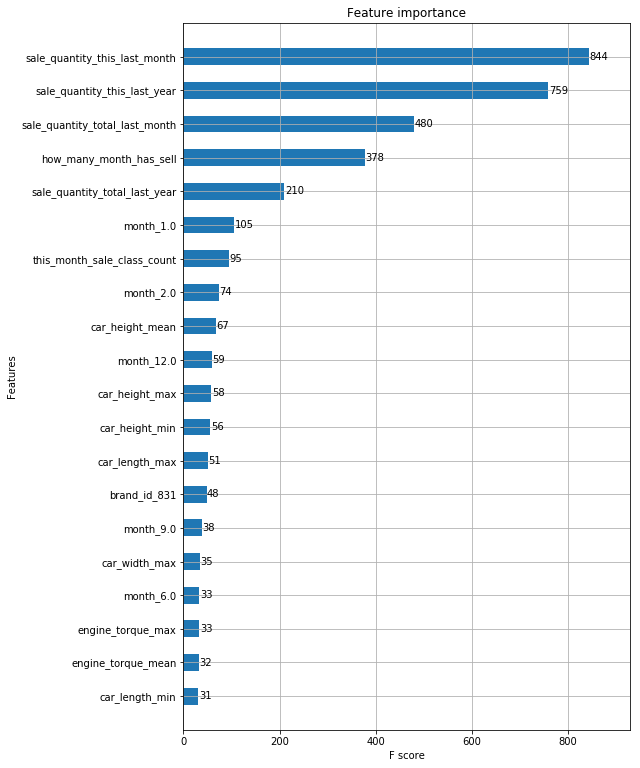

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(xgb9, max_num_features=20, height=0.5, ax=ax)

In [146]:
trainset = xgb.DMatrix(train_X,label=train_Y)
testset = xgb.DMatrix(test_X)

### 第二种：train完之后在predict

In [147]:
%%time

model=xgb.train(xgb9.get_params(),trainset,num_boost_round=10000,evals=watchlist)

[0]	train-rmse:494.438
[1]	train-rmse:453.211
[2]	train-rmse:415.193
[3]	train-rmse:381.363
[4]	train-rmse:353.229
[5]	train-rmse:327.051
[6]	train-rmse:304.205
[7]	train-rmse:282.733
[8]	train-rmse:264.806
[9]	train-rmse:248.042
[10]	train-rmse:233.845
[11]	train-rmse:221.018
[12]	train-rmse:209.463
[13]	train-rmse:199.566
[14]	train-rmse:190.708
[15]	train-rmse:182.478
[16]	train-rmse:175.762
[17]	train-rmse:168.738
[18]	train-rmse:163.098
[19]	train-rmse:158.064
[20]	train-rmse:153.423
[21]	train-rmse:149.759
[22]	train-rmse:146.172
[23]	train-rmse:142.594
[24]	train-rmse:139.546
[25]	train-rmse:136.889
[26]	train-rmse:134.955
[27]	train-rmse:132.649
[28]	train-rmse:130.892
[29]	train-rmse:128.604
[30]	train-rmse:127.139
[31]	train-rmse:125.078
[32]	train-rmse:123.511
[33]	train-rmse:121.804
[34]	train-rmse:120.019
[35]	train-rmse:118.818
[36]	train-rmse:117.994
[37]	train-rmse:117.02
[38]	train-rmse:116.14
[39]	train-rmse:115.363
[40]	train-rmse:114.287
[41]	train-rmse:113.378
[42]

[334]	train-rmse:54.3748
[335]	train-rmse:54.2891
[336]	train-rmse:54.1908
[337]	train-rmse:54.0724
[338]	train-rmse:53.996
[339]	train-rmse:53.9534
[340]	train-rmse:53.786
[341]	train-rmse:53.6958
[342]	train-rmse:53.5859
[343]	train-rmse:53.5111
[344]	train-rmse:53.3779
[345]	train-rmse:53.2954
[346]	train-rmse:53.199
[347]	train-rmse:53.1127
[348]	train-rmse:52.9916
[349]	train-rmse:52.9143
[350]	train-rmse:52.8553
[351]	train-rmse:52.7872
[352]	train-rmse:52.7081
[353]	train-rmse:52.5954
[354]	train-rmse:52.5397
[355]	train-rmse:52.4821
[356]	train-rmse:52.4071
[357]	train-rmse:52.3314
[358]	train-rmse:52.2027
[359]	train-rmse:52.1548
[360]	train-rmse:52.0391
[361]	train-rmse:51.9597
[362]	train-rmse:51.8503
[363]	train-rmse:51.7796
[364]	train-rmse:51.7454
[365]	train-rmse:51.6534
[366]	train-rmse:51.5622
[367]	train-rmse:51.4936
[368]	train-rmse:51.3931
[369]	train-rmse:51.3043
[370]	train-rmse:51.2053
[371]	train-rmse:51.0744
[372]	train-rmse:51.0208
[373]	train-rmse:50.9283
[37

[664]	train-rmse:35.8248
[665]	train-rmse:35.7794
[666]	train-rmse:35.7249
[667]	train-rmse:35.6717
[668]	train-rmse:35.6558
[669]	train-rmse:35.5934
[670]	train-rmse:35.5412
[671]	train-rmse:35.523
[672]	train-rmse:35.4907
[673]	train-rmse:35.4556
[674]	train-rmse:35.4287
[675]	train-rmse:35.3873
[676]	train-rmse:35.3455
[677]	train-rmse:35.3256
[678]	train-rmse:35.2823
[679]	train-rmse:35.2336
[680]	train-rmse:35.1744
[681]	train-rmse:35.1231
[682]	train-rmse:35.0782
[683]	train-rmse:35.0301
[684]	train-rmse:34.9876
[685]	train-rmse:34.965
[686]	train-rmse:34.9326
[687]	train-rmse:34.8856
[688]	train-rmse:34.8297
[689]	train-rmse:34.796
[690]	train-rmse:34.7451
[691]	train-rmse:34.7158
[692]	train-rmse:34.6645
[693]	train-rmse:34.6088
[694]	train-rmse:34.5802
[695]	train-rmse:34.5757
[696]	train-rmse:34.5266
[697]	train-rmse:34.4882
[698]	train-rmse:34.4293
[699]	train-rmse:34.4059
[700]	train-rmse:34.37
[701]	train-rmse:34.3409
[702]	train-rmse:34.3089
[703]	train-rmse:34.2711
[704]

[993]	train-rmse:25.6764
[994]	train-rmse:25.6613
[995]	train-rmse:25.6455
[996]	train-rmse:25.6154
[997]	train-rmse:25.5795
[998]	train-rmse:25.5378
[999]	train-rmse:25.5162
[1000]	train-rmse:25.4971
[1001]	train-rmse:25.4618
[1002]	train-rmse:25.4343
[1003]	train-rmse:25.3995
[1004]	train-rmse:25.3847
[1005]	train-rmse:25.3602
[1006]	train-rmse:25.3374
[1007]	train-rmse:25.3251
[1008]	train-rmse:25.2856
[1009]	train-rmse:25.2554
[1010]	train-rmse:25.2192
[1011]	train-rmse:25.2003
[1012]	train-rmse:25.1897
[1013]	train-rmse:25.1614
[1014]	train-rmse:25.1236
[1015]	train-rmse:25.1072
[1016]	train-rmse:25.0815
[1017]	train-rmse:25.0472
[1018]	train-rmse:25.0211
[1019]	train-rmse:24.9837
[1020]	train-rmse:24.9584
[1021]	train-rmse:24.9345
[1022]	train-rmse:24.9168
[1023]	train-rmse:24.8938
[1024]	train-rmse:24.8817
[1025]	train-rmse:24.8588
[1026]	train-rmse:24.8387
[1027]	train-rmse:24.8214
[1028]	train-rmse:24.7906
[1029]	train-rmse:24.7724
[1030]	train-rmse:24.7498
[1031]	train-rmse:2

[1309]	train-rmse:19.2004
[1310]	train-rmse:19.1763
[1311]	train-rmse:19.1582
[1312]	train-rmse:19.1366
[1313]	train-rmse:19.1211
[1314]	train-rmse:19.1142
[1315]	train-rmse:19.093
[1316]	train-rmse:19.0796
[1317]	train-rmse:19.0591
[1318]	train-rmse:19.0512
[1319]	train-rmse:19.046
[1320]	train-rmse:19.0346
[1321]	train-rmse:19.025
[1322]	train-rmse:19.0035
[1323]	train-rmse:18.9887
[1324]	train-rmse:18.9797
[1325]	train-rmse:18.9652
[1326]	train-rmse:18.9426
[1327]	train-rmse:18.9263
[1328]	train-rmse:18.9027
[1329]	train-rmse:18.8858
[1330]	train-rmse:18.8746
[1331]	train-rmse:18.8598
[1332]	train-rmse:18.8419
[1333]	train-rmse:18.8151
[1334]	train-rmse:18.8038
[1335]	train-rmse:18.7764
[1336]	train-rmse:18.7649
[1337]	train-rmse:18.7454
[1338]	train-rmse:18.7308
[1339]	train-rmse:18.7095
[1340]	train-rmse:18.6907
[1341]	train-rmse:18.6849
[1342]	train-rmse:18.6737
[1343]	train-rmse:18.6594
[1344]	train-rmse:18.6437
[1345]	train-rmse:18.6322
[1346]	train-rmse:18.6182
[1347]	train-rm

[1627]	train-rmse:14.8484
[1628]	train-rmse:14.8314
[1629]	train-rmse:14.8271
[1630]	train-rmse:14.8136
[1631]	train-rmse:14.8046
[1632]	train-rmse:14.7877
[1633]	train-rmse:14.7805
[1634]	train-rmse:14.7681
[1635]	train-rmse:14.7553
[1636]	train-rmse:14.7393
[1637]	train-rmse:14.724
[1638]	train-rmse:14.7114
[1639]	train-rmse:14.7025
[1640]	train-rmse:14.6972
[1641]	train-rmse:14.6877
[1642]	train-rmse:14.6801
[1643]	train-rmse:14.6709
[1644]	train-rmse:14.6583
[1645]	train-rmse:14.643
[1646]	train-rmse:14.627
[1647]	train-rmse:14.6132
[1648]	train-rmse:14.601
[1649]	train-rmse:14.5849
[1650]	train-rmse:14.5721
[1651]	train-rmse:14.5562
[1652]	train-rmse:14.5402
[1653]	train-rmse:14.5257
[1654]	train-rmse:14.5086
[1655]	train-rmse:14.4953
[1656]	train-rmse:14.4916
[1657]	train-rmse:14.4859
[1658]	train-rmse:14.4785
[1659]	train-rmse:14.4665
[1660]	train-rmse:14.4543
[1661]	train-rmse:14.4367
[1662]	train-rmse:14.4296
[1663]	train-rmse:14.4206
[1664]	train-rmse:14.4138
[1665]	train-rms

[1944]	train-rmse:11.6946
[1945]	train-rmse:11.6805
[1946]	train-rmse:11.6743
[1947]	train-rmse:11.6636
[1948]	train-rmse:11.6605
[1949]	train-rmse:11.6508
[1950]	train-rmse:11.6431
[1951]	train-rmse:11.6373
[1952]	train-rmse:11.6297
[1953]	train-rmse:11.6228
[1954]	train-rmse:11.6132
[1955]	train-rmse:11.6062
[1956]	train-rmse:11.5903
[1957]	train-rmse:11.5847
[1958]	train-rmse:11.5794
[1959]	train-rmse:11.5733
[1960]	train-rmse:11.5614
[1961]	train-rmse:11.5555
[1962]	train-rmse:11.5456
[1963]	train-rmse:11.5428
[1964]	train-rmse:11.5315
[1965]	train-rmse:11.5266
[1966]	train-rmse:11.5173
[1967]	train-rmse:11.5089
[1968]	train-rmse:11.5026
[1969]	train-rmse:11.493
[1970]	train-rmse:11.4845
[1971]	train-rmse:11.4733
[1972]	train-rmse:11.4711
[1973]	train-rmse:11.4598
[1974]	train-rmse:11.4533
[1975]	train-rmse:11.4434
[1976]	train-rmse:11.4368
[1977]	train-rmse:11.4263
[1978]	train-rmse:11.4174
[1979]	train-rmse:11.4054
[1980]	train-rmse:11.3987
[1981]	train-rmse:11.383
[1982]	train-r

[2260]	train-rmse:9.39553
[2261]	train-rmse:9.3912
[2262]	train-rmse:9.38929
[2263]	train-rmse:9.38342
[2264]	train-rmse:9.37281
[2265]	train-rmse:9.3679
[2266]	train-rmse:9.36181
[2267]	train-rmse:9.35812
[2268]	train-rmse:9.35249
[2269]	train-rmse:9.34638
[2270]	train-rmse:9.34064
[2271]	train-rmse:9.33591
[2272]	train-rmse:9.33094
[2273]	train-rmse:9.32794
[2274]	train-rmse:9.32429
[2275]	train-rmse:9.31773
[2276]	train-rmse:9.30608
[2277]	train-rmse:9.30106
[2278]	train-rmse:9.2943
[2279]	train-rmse:9.28521
[2280]	train-rmse:9.27902
[2281]	train-rmse:9.27
[2282]	train-rmse:9.25936
[2283]	train-rmse:9.2503
[2284]	train-rmse:9.2434
[2285]	train-rmse:9.23599
[2286]	train-rmse:9.23181
[2287]	train-rmse:9.22723
[2288]	train-rmse:9.226
[2289]	train-rmse:9.21867
[2290]	train-rmse:9.21289
[2291]	train-rmse:9.20554
[2292]	train-rmse:9.19937
[2293]	train-rmse:9.19547
[2294]	train-rmse:9.18463
[2295]	train-rmse:9.17886
[2296]	train-rmse:9.17502
[2297]	train-rmse:9.16668
[2298]	train-rmse:9.16

[2577]	train-rmse:7.57024
[2578]	train-rmse:7.56525
[2579]	train-rmse:7.56158
[2580]	train-rmse:7.55634
[2581]	train-rmse:7.54804
[2582]	train-rmse:7.54083
[2583]	train-rmse:7.53704
[2584]	train-rmse:7.53403
[2585]	train-rmse:7.53201
[2586]	train-rmse:7.52438
[2587]	train-rmse:7.51916
[2588]	train-rmse:7.5177
[2589]	train-rmse:7.51256
[2590]	train-rmse:7.50867
[2591]	train-rmse:7.50494
[2592]	train-rmse:7.50022
[2593]	train-rmse:7.49869
[2594]	train-rmse:7.4942
[2595]	train-rmse:7.49136
[2596]	train-rmse:7.48482
[2597]	train-rmse:7.4759
[2598]	train-rmse:7.46715
[2599]	train-rmse:7.46183
[2600]	train-rmse:7.45807
[2601]	train-rmse:7.4542
[2602]	train-rmse:7.45041
[2603]	train-rmse:7.44079
[2604]	train-rmse:7.43577
[2605]	train-rmse:7.43209
[2606]	train-rmse:7.42488
[2607]	train-rmse:7.41946
[2608]	train-rmse:7.41549
[2609]	train-rmse:7.4101
[2610]	train-rmse:7.40681
[2611]	train-rmse:7.40248
[2612]	train-rmse:7.40014
[2613]	train-rmse:7.39589
[2614]	train-rmse:7.39105
[2615]	train-rmse

[2894]	train-rmse:6.17281
[2895]	train-rmse:6.17006
[2896]	train-rmse:6.16659
[2897]	train-rmse:6.16148
[2898]	train-rmse:6.15733
[2899]	train-rmse:6.15412
[2900]	train-rmse:6.15121
[2901]	train-rmse:6.14936
[2902]	train-rmse:6.14364
[2903]	train-rmse:6.13795
[2904]	train-rmse:6.13468
[2905]	train-rmse:6.13147
[2906]	train-rmse:6.12925
[2907]	train-rmse:6.12703
[2908]	train-rmse:6.12497
[2909]	train-rmse:6.12298
[2910]	train-rmse:6.11923
[2911]	train-rmse:6.11298
[2912]	train-rmse:6.10893
[2913]	train-rmse:6.10548
[2914]	train-rmse:6.10327
[2915]	train-rmse:6.09707
[2916]	train-rmse:6.09214
[2917]	train-rmse:6.08998
[2918]	train-rmse:6.08713
[2919]	train-rmse:6.08298
[2920]	train-rmse:6.07913
[2921]	train-rmse:6.07315
[2922]	train-rmse:6.06856
[2923]	train-rmse:6.06637
[2924]	train-rmse:6.06333
[2925]	train-rmse:6.05753
[2926]	train-rmse:6.05526
[2927]	train-rmse:6.05087
[2928]	train-rmse:6.04484
[2929]	train-rmse:6.03849
[2930]	train-rmse:6.03134
[2931]	train-rmse:6.02885
[2932]	train

[3211]	train-rmse:5.09049
[3212]	train-rmse:5.08775
[3213]	train-rmse:5.08515
[3214]	train-rmse:5.08069
[3215]	train-rmse:5.07835
[3216]	train-rmse:5.07582
[3217]	train-rmse:5.07482
[3218]	train-rmse:5.07309
[3219]	train-rmse:5.07008
[3220]	train-rmse:5.06842
[3221]	train-rmse:5.06638
[3222]	train-rmse:5.06463
[3223]	train-rmse:5.061
[3224]	train-rmse:5.05808
[3225]	train-rmse:5.05469
[3226]	train-rmse:5.05341
[3227]	train-rmse:5.05129
[3228]	train-rmse:5.04875
[3229]	train-rmse:5.04634
[3230]	train-rmse:5.04327
[3231]	train-rmse:5.0407
[3232]	train-rmse:5.03742
[3233]	train-rmse:5.03686
[3234]	train-rmse:5.03485
[3235]	train-rmse:5.03362
[3236]	train-rmse:5.03122
[3237]	train-rmse:5.02831
[3238]	train-rmse:5.02666
[3239]	train-rmse:5.02382
[3240]	train-rmse:5.0208
[3241]	train-rmse:5.01659
[3242]	train-rmse:5.01326
[3243]	train-rmse:5.01119
[3244]	train-rmse:5.00788
[3245]	train-rmse:5.00385
[3246]	train-rmse:5.00146
[3247]	train-rmse:4.99873
[3248]	train-rmse:4.99516
[3249]	train-rms

[3528]	train-rmse:4.28192
[3529]	train-rmse:4.28105
[3530]	train-rmse:4.279
[3531]	train-rmse:4.27696
[3532]	train-rmse:4.27566
[3533]	train-rmse:4.27457
[3534]	train-rmse:4.27159
[3535]	train-rmse:4.26985
[3536]	train-rmse:4.26879
[3537]	train-rmse:4.26604
[3538]	train-rmse:4.26395
[3539]	train-rmse:4.26108
[3540]	train-rmse:4.25863
[3541]	train-rmse:4.25681
[3542]	train-rmse:4.25387
[3543]	train-rmse:4.25265
[3544]	train-rmse:4.25059
[3545]	train-rmse:4.24885
[3546]	train-rmse:4.24703
[3547]	train-rmse:4.24538
[3548]	train-rmse:4.24364
[3549]	train-rmse:4.24044
[3550]	train-rmse:4.23855
[3551]	train-rmse:4.23551
[3552]	train-rmse:4.2334
[3553]	train-rmse:4.22999
[3554]	train-rmse:4.22815
[3555]	train-rmse:4.22667
[3556]	train-rmse:4.22333
[3557]	train-rmse:4.22136
[3558]	train-rmse:4.21953
[3559]	train-rmse:4.21794
[3560]	train-rmse:4.21618
[3561]	train-rmse:4.21483
[3562]	train-rmse:4.21326
[3563]	train-rmse:4.21107
[3564]	train-rmse:4.20959
[3565]	train-rmse:4.20758
[3566]	train-rm

[3845]	train-rmse:3.63277
[3846]	train-rmse:3.63051
[3847]	train-rmse:3.62977
[3848]	train-rmse:3.62857
[3849]	train-rmse:3.62717
[3850]	train-rmse:3.62515
[3851]	train-rmse:3.6241
[3852]	train-rmse:3.6223
[3853]	train-rmse:3.62043
[3854]	train-rmse:3.61829
[3855]	train-rmse:3.61591
[3856]	train-rmse:3.61486
[3857]	train-rmse:3.61344
[3858]	train-rmse:3.61184
[3859]	train-rmse:3.6108
[3860]	train-rmse:3.60852
[3861]	train-rmse:3.60721
[3862]	train-rmse:3.60555
[3863]	train-rmse:3.60324
[3864]	train-rmse:3.60169
[3865]	train-rmse:3.59867
[3866]	train-rmse:3.597
[3867]	train-rmse:3.59567
[3868]	train-rmse:3.59381
[3869]	train-rmse:3.5914
[3870]	train-rmse:3.59008
[3871]	train-rmse:3.58884
[3872]	train-rmse:3.58767
[3873]	train-rmse:3.5861
[3874]	train-rmse:3.58457
[3875]	train-rmse:3.58214
[3876]	train-rmse:3.57944
[3877]	train-rmse:3.57712
[3878]	train-rmse:3.57572
[3879]	train-rmse:3.57306
[3880]	train-rmse:3.57163
[3881]	train-rmse:3.56911
[3882]	train-rmse:3.56792
[3883]	train-rmse:3

[4163]	train-rmse:3.11304
[4164]	train-rmse:3.11162
[4165]	train-rmse:3.11047
[4166]	train-rmse:3.10926
[4167]	train-rmse:3.1086
[4168]	train-rmse:3.1075
[4169]	train-rmse:3.10604
[4170]	train-rmse:3.10415
[4171]	train-rmse:3.10262
[4172]	train-rmse:3.10108
[4173]	train-rmse:3.09966
[4174]	train-rmse:3.09894
[4175]	train-rmse:3.09717
[4176]	train-rmse:3.09538
[4177]	train-rmse:3.09376
[4178]	train-rmse:3.09233
[4179]	train-rmse:3.09095
[4180]	train-rmse:3.08988
[4181]	train-rmse:3.08848
[4182]	train-rmse:3.0871
[4183]	train-rmse:3.08559
[4184]	train-rmse:3.08485
[4185]	train-rmse:3.08309
[4186]	train-rmse:3.08148
[4187]	train-rmse:3.07961
[4188]	train-rmse:3.07773
[4189]	train-rmse:3.0767
[4190]	train-rmse:3.07518
[4191]	train-rmse:3.07434
[4192]	train-rmse:3.07268
[4193]	train-rmse:3.06952
[4194]	train-rmse:3.06765
[4195]	train-rmse:3.06608
[4196]	train-rmse:3.06522
[4197]	train-rmse:3.06259
[4198]	train-rmse:3.06094
[4199]	train-rmse:3.05905
[4200]	train-rmse:3.05757
[4201]	train-rms

[4480]	train-rmse:2.68522
[4481]	train-rmse:2.68456
[4482]	train-rmse:2.68376
[4483]	train-rmse:2.68233
[4484]	train-rmse:2.68111
[4485]	train-rmse:2.67935
[4486]	train-rmse:2.6776
[4487]	train-rmse:2.67649
[4488]	train-rmse:2.67449
[4489]	train-rmse:2.67349
[4490]	train-rmse:2.67197
[4491]	train-rmse:2.67099
[4492]	train-rmse:2.66959
[4493]	train-rmse:2.66836
[4494]	train-rmse:2.66719
[4495]	train-rmse:2.66628
[4496]	train-rmse:2.6646
[4497]	train-rmse:2.66275
[4498]	train-rmse:2.66204
[4499]	train-rmse:2.66014
[4500]	train-rmse:2.65976
[4501]	train-rmse:2.65913
[4502]	train-rmse:2.65776
[4503]	train-rmse:2.65651
[4504]	train-rmse:2.65519
[4505]	train-rmse:2.65416
[4506]	train-rmse:2.65322
[4507]	train-rmse:2.65132
[4508]	train-rmse:2.6496
[4509]	train-rmse:2.64798
[4510]	train-rmse:2.64684
[4511]	train-rmse:2.64558
[4512]	train-rmse:2.64472
[4513]	train-rmse:2.64369
[4514]	train-rmse:2.64264
[4515]	train-rmse:2.6413
[4516]	train-rmse:2.63966
[4517]	train-rmse:2.63846
[4518]	train-rms

[4797]	train-rmse:2.33637
[4798]	train-rmse:2.33545
[4799]	train-rmse:2.33433
[4800]	train-rmse:2.33341
[4801]	train-rmse:2.33287
[4802]	train-rmse:2.33225
[4803]	train-rmse:2.33074
[4804]	train-rmse:2.32949
[4805]	train-rmse:2.32837
[4806]	train-rmse:2.32601
[4807]	train-rmse:2.32496
[4808]	train-rmse:2.3237
[4809]	train-rmse:2.32233
[4810]	train-rmse:2.32152
[4811]	train-rmse:2.32025
[4812]	train-rmse:2.31866
[4813]	train-rmse:2.31717
[4814]	train-rmse:2.31634
[4815]	train-rmse:2.31551
[4816]	train-rmse:2.31442
[4817]	train-rmse:2.31286
[4818]	train-rmse:2.31236
[4819]	train-rmse:2.31177
[4820]	train-rmse:2.31098
[4821]	train-rmse:2.31004
[4822]	train-rmse:2.30898
[4823]	train-rmse:2.30815
[4824]	train-rmse:2.30731
[4825]	train-rmse:2.30611
[4826]	train-rmse:2.30519
[4827]	train-rmse:2.30463
[4828]	train-rmse:2.30384
[4829]	train-rmse:2.30252
[4830]	train-rmse:2.30228
[4831]	train-rmse:2.30132
[4832]	train-rmse:2.30009
[4833]	train-rmse:2.29908
[4834]	train-rmse:2.29778
[4835]	train-

[5114]	train-rmse:2.03861
[5115]	train-rmse:2.03741
[5116]	train-rmse:2.03653
[5117]	train-rmse:2.03545
[5118]	train-rmse:2.03487
[5119]	train-rmse:2.03419
[5120]	train-rmse:2.03367
[5121]	train-rmse:2.03305
[5122]	train-rmse:2.0319
[5123]	train-rmse:2.03114
[5124]	train-rmse:2.0296
[5125]	train-rmse:2.02849
[5126]	train-rmse:2.0277
[5127]	train-rmse:2.0267
[5128]	train-rmse:2.0263
[5129]	train-rmse:2.02567
[5130]	train-rmse:2.02475
[5131]	train-rmse:2.02408
[5132]	train-rmse:2.02354
[5133]	train-rmse:2.02286
[5134]	train-rmse:2.02212
[5135]	train-rmse:2.02154
[5136]	train-rmse:2.02067
[5137]	train-rmse:2.02017
[5138]	train-rmse:2.01945
[5139]	train-rmse:2.01865
[5140]	train-rmse:2.01783
[5141]	train-rmse:2.01717
[5142]	train-rmse:2.01607
[5143]	train-rmse:2.01518
[5144]	train-rmse:2.01437
[5145]	train-rmse:2.01378
[5146]	train-rmse:2.01297
[5147]	train-rmse:2.01237
[5148]	train-rmse:2.01152
[5149]	train-rmse:2.01049
[5150]	train-rmse:2.00975
[5151]	train-rmse:2.00887
[5152]	train-rmse

[5432]	train-rmse:1.79192
[5433]	train-rmse:1.79108
[5434]	train-rmse:1.79051
[5435]	train-rmse:1.78989
[5436]	train-rmse:1.7892
[5437]	train-rmse:1.78866
[5438]	train-rmse:1.78826
[5439]	train-rmse:1.78769
[5440]	train-rmse:1.78696
[5441]	train-rmse:1.7864
[5442]	train-rmse:1.78581
[5443]	train-rmse:1.78539
[5444]	train-rmse:1.78459
[5445]	train-rmse:1.78418
[5446]	train-rmse:1.78324
[5447]	train-rmse:1.78282
[5448]	train-rmse:1.78239
[5449]	train-rmse:1.78166
[5450]	train-rmse:1.78086
[5451]	train-rmse:1.77996
[5452]	train-rmse:1.77959
[5453]	train-rmse:1.77887
[5454]	train-rmse:1.77794
[5455]	train-rmse:1.77757
[5456]	train-rmse:1.77679
[5457]	train-rmse:1.77616
[5458]	train-rmse:1.77546
[5459]	train-rmse:1.77406
[5460]	train-rmse:1.77351
[5461]	train-rmse:1.77292
[5462]	train-rmse:1.77217
[5463]	train-rmse:1.77142
[5464]	train-rmse:1.77039
[5465]	train-rmse:1.77
[5466]	train-rmse:1.76967
[5467]	train-rmse:1.7683
[5468]	train-rmse:1.76804
[5469]	train-rmse:1.76717
[5470]	train-rmse:

[5749]	train-rmse:1.58289
[5750]	train-rmse:1.58233
[5751]	train-rmse:1.58175
[5752]	train-rmse:1.58114
[5753]	train-rmse:1.58049
[5754]	train-rmse:1.57994
[5755]	train-rmse:1.57913
[5756]	train-rmse:1.57851
[5757]	train-rmse:1.57774
[5758]	train-rmse:1.57723
[5759]	train-rmse:1.57686
[5760]	train-rmse:1.57633
[5761]	train-rmse:1.57556
[5762]	train-rmse:1.57481
[5763]	train-rmse:1.57412
[5764]	train-rmse:1.57351
[5765]	train-rmse:1.57279
[5766]	train-rmse:1.57232
[5767]	train-rmse:1.572
[5768]	train-rmse:1.57161
[5769]	train-rmse:1.57099
[5770]	train-rmse:1.56961
[5771]	train-rmse:1.56885
[5772]	train-rmse:1.56833
[5773]	train-rmse:1.56808
[5774]	train-rmse:1.56765
[5775]	train-rmse:1.56713
[5776]	train-rmse:1.56644
[5777]	train-rmse:1.56594
[5778]	train-rmse:1.56516
[5779]	train-rmse:1.56435
[5780]	train-rmse:1.56368
[5781]	train-rmse:1.56326
[5782]	train-rmse:1.56287
[5783]	train-rmse:1.56263
[5784]	train-rmse:1.56197
[5785]	train-rmse:1.56108
[5786]	train-rmse:1.56071
[5787]	train-r

[6066]	train-rmse:1.41362
[6067]	train-rmse:1.41286
[6068]	train-rmse:1.41241
[6069]	train-rmse:1.41195
[6070]	train-rmse:1.41157
[6071]	train-rmse:1.41088
[6072]	train-rmse:1.41048
[6073]	train-rmse:1.41015
[6074]	train-rmse:1.40943
[6075]	train-rmse:1.40875
[6076]	train-rmse:1.40829
[6077]	train-rmse:1.40782
[6078]	train-rmse:1.40722
[6079]	train-rmse:1.40682
[6080]	train-rmse:1.40639
[6081]	train-rmse:1.40586
[6082]	train-rmse:1.40532
[6083]	train-rmse:1.40489
[6084]	train-rmse:1.40417
[6085]	train-rmse:1.40358
[6086]	train-rmse:1.40311
[6087]	train-rmse:1.40277
[6088]	train-rmse:1.40204
[6089]	train-rmse:1.40157
[6090]	train-rmse:1.40134
[6091]	train-rmse:1.40055
[6092]	train-rmse:1.40019
[6093]	train-rmse:1.39978
[6094]	train-rmse:1.39916
[6095]	train-rmse:1.39869
[6096]	train-rmse:1.39823
[6097]	train-rmse:1.39761
[6098]	train-rmse:1.397
[6099]	train-rmse:1.39662
[6100]	train-rmse:1.39623
[6101]	train-rmse:1.39567
[6102]	train-rmse:1.39499
[6103]	train-rmse:1.39421
[6104]	train-r

[6383]	train-rmse:1.26005
[6384]	train-rmse:1.25936
[6385]	train-rmse:1.25881
[6386]	train-rmse:1.25843
[6387]	train-rmse:1.25806
[6388]	train-rmse:1.2573
[6389]	train-rmse:1.25697
[6390]	train-rmse:1.25653
[6391]	train-rmse:1.25575
[6392]	train-rmse:1.25542
[6393]	train-rmse:1.25507
[6394]	train-rmse:1.25469
[6395]	train-rmse:1.2542
[6396]	train-rmse:1.25284
[6397]	train-rmse:1.25264
[6398]	train-rmse:1.25233
[6399]	train-rmse:1.25213
[6400]	train-rmse:1.25168
[6401]	train-rmse:1.25132
[6402]	train-rmse:1.25099
[6403]	train-rmse:1.25036
[6404]	train-rmse:1.24946
[6405]	train-rmse:1.24903
[6406]	train-rmse:1.24861
[6407]	train-rmse:1.24802
[6408]	train-rmse:1.24719
[6409]	train-rmse:1.24685
[6410]	train-rmse:1.24661
[6411]	train-rmse:1.24599
[6412]	train-rmse:1.24536
[6413]	train-rmse:1.24515
[6414]	train-rmse:1.24371
[6415]	train-rmse:1.24314
[6416]	train-rmse:1.24255
[6417]	train-rmse:1.24235
[6418]	train-rmse:1.2419
[6419]	train-rmse:1.24153
[6420]	train-rmse:1.24115
[6421]	train-rm

[6700]	train-rmse:1.12512
[6701]	train-rmse:1.12483
[6702]	train-rmse:1.12458
[6703]	train-rmse:1.12405
[6704]	train-rmse:1.12372
[6705]	train-rmse:1.12324
[6706]	train-rmse:1.12271
[6707]	train-rmse:1.12235
[6708]	train-rmse:1.12168
[6709]	train-rmse:1.12113
[6710]	train-rmse:1.12094
[6711]	train-rmse:1.1205
[6712]	train-rmse:1.12023
[6713]	train-rmse:1.11986
[6714]	train-rmse:1.1195
[6715]	train-rmse:1.11923
[6716]	train-rmse:1.11878
[6717]	train-rmse:1.11831
[6718]	train-rmse:1.11803
[6719]	train-rmse:1.1176
[6720]	train-rmse:1.11731
[6721]	train-rmse:1.11692
[6722]	train-rmse:1.11659
[6723]	train-rmse:1.11614
[6724]	train-rmse:1.11566
[6725]	train-rmse:1.11549
[6726]	train-rmse:1.11498
[6727]	train-rmse:1.11453
[6728]	train-rmse:1.11411
[6729]	train-rmse:1.11352
[6730]	train-rmse:1.11315
[6731]	train-rmse:1.11294
[6732]	train-rmse:1.11238
[6733]	train-rmse:1.11195
[6734]	train-rmse:1.11168
[6735]	train-rmse:1.11137
[6736]	train-rmse:1.11111
[6737]	train-rmse:1.11053
[6738]	train-rm

[7017]	train-rmse:1.01065
[7018]	train-rmse:1.01041
[7019]	train-rmse:1.00994
[7020]	train-rmse:1.0095
[7021]	train-rmse:1.00918
[7022]	train-rmse:1.00895
[7023]	train-rmse:1.0088
[7024]	train-rmse:1.00846
[7025]	train-rmse:1.00816
[7026]	train-rmse:1.00778
[7027]	train-rmse:1.00762
[7028]	train-rmse:1.00714
[7029]	train-rmse:1.0064
[7030]	train-rmse:1.00591
[7031]	train-rmse:1.00566
[7032]	train-rmse:1.00537
[7033]	train-rmse:1.00497
[7034]	train-rmse:1.00464
[7035]	train-rmse:1.00433
[7036]	train-rmse:1.00397
[7037]	train-rmse:1.00378
[7038]	train-rmse:1.00349
[7039]	train-rmse:1.00307
[7040]	train-rmse:1.00279
[7041]	train-rmse:1.00248
[7042]	train-rmse:1.00222
[7043]	train-rmse:1.00194
[7044]	train-rmse:1.00179
[7045]	train-rmse:1.00152
[7046]	train-rmse:1.00134
[7047]	train-rmse:1.00116
[7048]	train-rmse:1.0009
[7049]	train-rmse:1.00072
[7050]	train-rmse:1.00041
[7051]	train-rmse:1.00015
[7052]	train-rmse:0.999422
[7053]	train-rmse:0.999191
[7054]	train-rmse:0.998887
[7055]	train-

[7324]	train-rmse:0.913047
[7325]	train-rmse:0.912641
[7326]	train-rmse:0.912364
[7327]	train-rmse:0.912091
[7328]	train-rmse:0.911887
[7329]	train-rmse:0.911429
[7330]	train-rmse:0.911253
[7331]	train-rmse:0.911087
[7332]	train-rmse:0.910787
[7333]	train-rmse:0.910478
[7334]	train-rmse:0.910176
[7335]	train-rmse:0.909932
[7336]	train-rmse:0.909652
[7337]	train-rmse:0.909536
[7338]	train-rmse:0.909356
[7339]	train-rmse:0.909073
[7340]	train-rmse:0.908678
[7341]	train-rmse:0.90841
[7342]	train-rmse:0.908213
[7343]	train-rmse:0.908036
[7344]	train-rmse:0.907681
[7345]	train-rmse:0.907358
[7346]	train-rmse:0.907132
[7347]	train-rmse:0.906898
[7348]	train-rmse:0.90637
[7349]	train-rmse:0.906193
[7350]	train-rmse:0.905765
[7351]	train-rmse:0.905495
[7352]	train-rmse:0.905202
[7353]	train-rmse:0.905027
[7354]	train-rmse:0.904752
[7355]	train-rmse:0.904406
[7356]	train-rmse:0.904049
[7357]	train-rmse:0.903679
[7358]	train-rmse:0.903474
[7359]	train-rmse:0.903213
[7360]	train-rmse:0.902946
[73

[7629]	train-rmse:0.828184
[7630]	train-rmse:0.827929
[7631]	train-rmse:0.827605
[7632]	train-rmse:0.827425
[7633]	train-rmse:0.827305
[7634]	train-rmse:0.826983
[7635]	train-rmse:0.826694
[7636]	train-rmse:0.826406
[7637]	train-rmse:0.826086
[7638]	train-rmse:0.825851
[7639]	train-rmse:0.82563
[7640]	train-rmse:0.825434
[7641]	train-rmse:0.82506
[7642]	train-rmse:0.824676
[7643]	train-rmse:0.824398
[7644]	train-rmse:0.824018
[7645]	train-rmse:0.823761
[7646]	train-rmse:0.823517
[7647]	train-rmse:0.823164
[7648]	train-rmse:0.822884
[7649]	train-rmse:0.822647
[7650]	train-rmse:0.822382
[7651]	train-rmse:0.822158
[7652]	train-rmse:0.821972
[7653]	train-rmse:0.821748
[7654]	train-rmse:0.821569
[7655]	train-rmse:0.82133
[7656]	train-rmse:0.821186
[7657]	train-rmse:0.82095
[7658]	train-rmse:0.820552
[7659]	train-rmse:0.820354
[7660]	train-rmse:0.819932
[7661]	train-rmse:0.819733
[7662]	train-rmse:0.819502
[7663]	train-rmse:0.819024
[7664]	train-rmse:0.818863
[7665]	train-rmse:0.818621
[7666

[7934]	train-rmse:0.756273
[7935]	train-rmse:0.756142
[7936]	train-rmse:0.755905
[7937]	train-rmse:0.755717
[7938]	train-rmse:0.755387
[7939]	train-rmse:0.755254
[7940]	train-rmse:0.754921
[7941]	train-rmse:0.754573
[7942]	train-rmse:0.754448
[7943]	train-rmse:0.754347
[7944]	train-rmse:0.754089
[7945]	train-rmse:0.753815
[7946]	train-rmse:0.753551
[7947]	train-rmse:0.753357
[7948]	train-rmse:0.753133
[7949]	train-rmse:0.752913
[7950]	train-rmse:0.752491
[7951]	train-rmse:0.7522
[7952]	train-rmse:0.752005
[7953]	train-rmse:0.751815
[7954]	train-rmse:0.751593
[7955]	train-rmse:0.751302
[7956]	train-rmse:0.751195
[7957]	train-rmse:0.750946
[7958]	train-rmse:0.750664
[7959]	train-rmse:0.750354
[7960]	train-rmse:0.750029
[7961]	train-rmse:0.749606
[7962]	train-rmse:0.749431
[7963]	train-rmse:0.749022
[7964]	train-rmse:0.748829
[7965]	train-rmse:0.748552
[7966]	train-rmse:0.748351
[7967]	train-rmse:0.748097
[7968]	train-rmse:0.748011
[7969]	train-rmse:0.747838
[7970]	train-rmse:0.74776
[797

[8239]	train-rmse:0.692047
[8240]	train-rmse:0.69175
[8241]	train-rmse:0.691642
[8242]	train-rmse:0.691485
[8243]	train-rmse:0.691242
[8244]	train-rmse:0.690983
[8245]	train-rmse:0.690687
[8246]	train-rmse:0.690483
[8247]	train-rmse:0.690343
[8248]	train-rmse:0.690109
[8249]	train-rmse:0.689902
[8250]	train-rmse:0.689814
[8251]	train-rmse:0.689673
[8252]	train-rmse:0.689411
[8253]	train-rmse:0.689302
[8254]	train-rmse:0.68916
[8255]	train-rmse:0.68899
[8256]	train-rmse:0.688791
[8257]	train-rmse:0.688625
[8258]	train-rmse:0.688369
[8259]	train-rmse:0.687976
[8260]	train-rmse:0.687806
[8261]	train-rmse:0.687564
[8262]	train-rmse:0.687301
[8263]	train-rmse:0.686971
[8264]	train-rmse:0.686818
[8265]	train-rmse:0.686624
[8266]	train-rmse:0.686413
[8267]	train-rmse:0.686155
[8268]	train-rmse:0.685858
[8269]	train-rmse:0.685649
[8270]	train-rmse:0.685335
[8271]	train-rmse:0.684876
[8272]	train-rmse:0.684664
[8273]	train-rmse:0.684337
[8274]	train-rmse:0.684132
[8275]	train-rmse:0.684018
[827

[8544]	train-rmse:0.63458
[8545]	train-rmse:0.634319
[8546]	train-rmse:0.634113
[8547]	train-rmse:0.633972
[8548]	train-rmse:0.633792
[8549]	train-rmse:0.633693
[8550]	train-rmse:0.633435
[8551]	train-rmse:0.633267
[8552]	train-rmse:0.633075
[8553]	train-rmse:0.632885
[8554]	train-rmse:0.63272
[8555]	train-rmse:0.632547
[8556]	train-rmse:0.632432
[8557]	train-rmse:0.632161
[8558]	train-rmse:0.632052
[8559]	train-rmse:0.63195
[8560]	train-rmse:0.631697
[8561]	train-rmse:0.631598
[8562]	train-rmse:0.63146
[8563]	train-rmse:0.631356
[8564]	train-rmse:0.631193
[8565]	train-rmse:0.630876
[8566]	train-rmse:0.63067
[8567]	train-rmse:0.630478
[8568]	train-rmse:0.630184
[8569]	train-rmse:0.629958
[8570]	train-rmse:0.629699
[8571]	train-rmse:0.629548
[8572]	train-rmse:0.629293
[8573]	train-rmse:0.629191
[8574]	train-rmse:0.629094
[8575]	train-rmse:0.628913
[8576]	train-rmse:0.628692
[8577]	train-rmse:0.628556
[8578]	train-rmse:0.628449
[8579]	train-rmse:0.628313
[8580]	train-rmse:0.628097
[8581]

[8849]	train-rmse:0.582364
[8850]	train-rmse:0.582119
[8851]	train-rmse:0.581996
[8852]	train-rmse:0.581928
[8853]	train-rmse:0.58171
[8854]	train-rmse:0.581626
[8855]	train-rmse:0.581311
[8856]	train-rmse:0.581229
[8857]	train-rmse:0.581147
[8858]	train-rmse:0.580987
[8859]	train-rmse:0.580742
[8860]	train-rmse:0.580547
[8861]	train-rmse:0.580414
[8862]	train-rmse:0.580256
[8863]	train-rmse:0.580075
[8864]	train-rmse:0.579938
[8865]	train-rmse:0.579764
[8866]	train-rmse:0.57965
[8867]	train-rmse:0.57949
[8868]	train-rmse:0.579215
[8869]	train-rmse:0.579037
[8870]	train-rmse:0.578942
[8871]	train-rmse:0.578682
[8872]	train-rmse:0.578517
[8873]	train-rmse:0.578306
[8874]	train-rmse:0.578193
[8875]	train-rmse:0.578088
[8876]	train-rmse:0.57788
[8877]	train-rmse:0.577749
[8878]	train-rmse:0.577668
[8879]	train-rmse:0.577485
[8880]	train-rmse:0.577381
[8881]	train-rmse:0.577294
[8882]	train-rmse:0.577132
[8883]	train-rmse:0.576974
[8884]	train-rmse:0.576868
[8885]	train-rmse:0.576766
[8886

[9154]	train-rmse:0.535337
[9155]	train-rmse:0.535283
[9156]	train-rmse:0.535121
[9157]	train-rmse:0.535007
[9158]	train-rmse:0.534769
[9159]	train-rmse:0.534676
[9160]	train-rmse:0.534506
[9161]	train-rmse:0.534394
[9162]	train-rmse:0.5342
[9163]	train-rmse:0.533999
[9164]	train-rmse:0.533951
[9165]	train-rmse:0.533813
[9166]	train-rmse:0.533768
[9167]	train-rmse:0.533665
[9168]	train-rmse:0.533492
[9169]	train-rmse:0.533332
[9170]	train-rmse:0.533252
[9171]	train-rmse:0.533168
[9172]	train-rmse:0.533059
[9173]	train-rmse:0.532833
[9174]	train-rmse:0.532635
[9175]	train-rmse:0.532559
[9176]	train-rmse:0.532465
[9177]	train-rmse:0.532323
[9178]	train-rmse:0.532161
[9179]	train-rmse:0.532073
[9180]	train-rmse:0.531926
[9181]	train-rmse:0.531841
[9182]	train-rmse:0.531685
[9183]	train-rmse:0.531538
[9184]	train-rmse:0.53142
[9185]	train-rmse:0.531332
[9186]	train-rmse:0.53122
[9187]	train-rmse:0.531114
[9188]	train-rmse:0.530998
[9189]	train-rmse:0.530681
[9190]	train-rmse:0.530521
[9191

[9459]	train-rmse:0.495053
[9460]	train-rmse:0.494948
[9461]	train-rmse:0.494792
[9462]	train-rmse:0.494651
[9463]	train-rmse:0.494576
[9464]	train-rmse:0.49443
[9465]	train-rmse:0.494328
[9466]	train-rmse:0.494264
[9467]	train-rmse:0.494114
[9468]	train-rmse:0.494036
[9469]	train-rmse:0.493853
[9470]	train-rmse:0.493743
[9471]	train-rmse:0.493661
[9472]	train-rmse:0.493518
[9473]	train-rmse:0.493398
[9474]	train-rmse:0.493226
[9475]	train-rmse:0.493096
[9476]	train-rmse:0.492854
[9477]	train-rmse:0.492704
[9478]	train-rmse:0.492556
[9479]	train-rmse:0.492438
[9480]	train-rmse:0.492341
[9481]	train-rmse:0.492232
[9482]	train-rmse:0.492173
[9483]	train-rmse:0.492032
[9484]	train-rmse:0.491961
[9485]	train-rmse:0.491813
[9486]	train-rmse:0.491756
[9487]	train-rmse:0.491629
[9488]	train-rmse:0.491454
[9489]	train-rmse:0.491213
[9490]	train-rmse:0.491124
[9491]	train-rmse:0.491023
[9492]	train-rmse:0.490995
[9493]	train-rmse:0.490951
[9494]	train-rmse:0.490806
[9495]	train-rmse:0.490554
[9

[9764]	train-rmse:0.457318
[9765]	train-rmse:0.457219
[9766]	train-rmse:0.457126
[9767]	train-rmse:0.457012
[9768]	train-rmse:0.456881
[9769]	train-rmse:0.456797
[9770]	train-rmse:0.456636
[9771]	train-rmse:0.456473
[9772]	train-rmse:0.456291
[9773]	train-rmse:0.456118
[9774]	train-rmse:0.456064
[9775]	train-rmse:0.455983
[9776]	train-rmse:0.455837
[9777]	train-rmse:0.455672
[9778]	train-rmse:0.455603
[9779]	train-rmse:0.455504
[9780]	train-rmse:0.455336
[9781]	train-rmse:0.4552
[9782]	train-rmse:0.455156
[9783]	train-rmse:0.454989
[9784]	train-rmse:0.454758
[9785]	train-rmse:0.454618
[9786]	train-rmse:0.454549
[9787]	train-rmse:0.454463
[9788]	train-rmse:0.454291
[9789]	train-rmse:0.454068
[9790]	train-rmse:0.453943
[9791]	train-rmse:0.453835
[9792]	train-rmse:0.453794
[9793]	train-rmse:0.453702
[9794]	train-rmse:0.4536
[9795]	train-rmse:0.453545
[9796]	train-rmse:0.453443
[9797]	train-rmse:0.453332
[9798]	train-rmse:0.453277
[9799]	train-rmse:0.453222
[9800]	train-rmse:0.45309
[9801]

In [148]:
test_predict=model.predict(testset)

In [149]:
rmse_test_10=sqrt(mean_squared_error(test_predict,test_Y))

In [137]:
rmse_test_10

168.7448358242037

注意；这里看着第一种方案比第二种方案似乎表现更好一些，但是如果我们拿到线上去测试，会发现第一种方案实际效果差很多。

### 初步原因
上图树图是fit 下图树图是train，初步观察到：两个图在前三层节点都是一样的，第四和第五层train节点明显比fit要多，更茂密的树应该是鲁棒性(robust)更好一些，这一点应该是初步可以解释train比fit效果更好的原因
关于Grandient Boosting的原理可以参考这篇文章[Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)

![xgb_fit_tree](https://user-images.githubusercontent.com/21167490/36014954-48ec6eea-0da7-11e8-95c8-0b3c0f1d9572.png)

![xgb_train_tree](https://user-images.githubusercontent.com/21167490/36014967-5400c830-0da7-11e8-8ac5-21b86d03050f.png)